# Preliminary XGBoost
This notebook outlines preliminary work done to tune the XGBoost classifier. **The results in this notebook are superceeded by those in `xgb_tuning.ipynb` for the purposes of the report.** This notebook does however show comparable results for gradient boosting and explores a broader design space. The results from this notebook were used in part as the basis of understanding in order to set the initial hyperparameter values for the final tuning process. 

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

classes = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


def plot_mc_roc(Y_test_bin, Y_test_proba, n_classes, title='ROC Curve'):
    ax = plt.axes()
    leg = []
    auc_sum = 0
    for i in range(n_classes):
        y_score = Y_test_proba[:, i]
        fpr, tpr, _ = roc_curve(Y_test_bin[:, i], y_score)
        roc_auc = auc(fpr, tpr)
        auc_sum += roc_auc
        leg.append(classes[i] + ' (auc = {:.4})'.format(roc_auc))
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)

    plt.xlim((0, .4))
    plt.ylim((.6, 1))
    plt.legend(leg, loc='lower right')
    plt.title(title)
    print('Unweighted Average AUC: {:.4}'.format(auc_sum/n_classes))


In [2]:
import pandas as pd

# read in all data
test = pd.read_csv('../data/test.txt', delimiter=';', names=['text', 'target'])
train = pd.read_csv('../data/train.txt', delimiter=';',
                    names=['text', 'target'])
val = pd.read_csv('../data/val.txt', delimiter=';', names=['text', 'target'])
trainval = pd.concat([train,val])
testval = pd.concat([test,val])

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# create vectorier for BoW
vectorizer = CountVectorizer(max_df=0.5, min_df=5, stop_words='english', ngram_range=(1, 1))
BoW = vectorizer.fit_transform(trainval.text)
print('Number of Features in BoW: ', len(vectorizer.get_feature_names_out()))

enc = LabelEncoder().fit(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

# transform all the data
X_trainval = vectorizer.transform(trainval.text).toarray()
Y_trainval = enc.transform(trainval.target)
X_train = vectorizer.transform(train.text).toarray()
Y_train = enc.transform(train.target)
X_val = vectorizer.transform(val.text).toarray()
Y_val = enc.transform(val.target)
X_test = vectorizer.transform(test.text).toarray()
Y_test = enc.transform(test.target)

Number of Features in BoW:  3397


## Coarse Hyperparameter Search
Performing a course randomized search cross-validation to get an estimate of where the best model resides in the design space. Further tuning and optimization will be performed based on the results of the randomized cross-validation.

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

clf = XGBClassifier(random_state=0, eval_metric='mlogloss', use_label_encoder=False)

params = {'n_estimators':[10, 50, 100, 250, 500],
          'max_depth':[1, 5, 10, 25, 50],
          'reg_alpha':[0, .1, 1, 10, 100],
          'learning_rate':[.01, .1, .25, .5, 1]
          }

#grid_cv = GridSearchCV(clf,param_grid=params, scoring='f1_macro', verbose=3, n_jobs=1, cv=5)
rand_cv = RandomizedSearchCV(clf, param_distributions=params, n_iter=25, n_jobs=-1, verbose=1, scoring='f1_macro', cv=2, random_state=0)
rand_cv.fit(X_trainval, Y_trainval)


Fitting 2 folds for each of 25 candidates, totalling 50 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=n...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

Best Parameters:  {'reg_alpha': 0, 'n_estimators': 50, 'max_depth': 25, 'learning_rate': 0.5}
Best Score:  0.8562777731856552


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,mean_test_score,std_test_score,rank_test_score
7,1956.732203,0.278256,0.726059,0.016955,0.0,50.0,25.0,0.50,0.856278,0.000464,1
8,3795.248049,2.996988,1.262126,0.117186,1.0,500.0,5.0,1.00,0.855536,0.000719,2
0,3753.074003,0.391952,1.221235,0.020445,0.1,50.0,50.0,0.25,0.854635,0.000892,3
17,2018.713057,2.025694,1.782696,0.588007,0.1,100.0,10.0,0.50,0.854439,0.000261,4
6,7862.493680,12.476177,2.832842,0.195687,0.0,100.0,50.0,0.10,0.854203,0.000959,5
24,3367.773519,1.702448,0.811330,0.045378,0.0,500.0,5.0,1.00,0.851005,0.000704,6
16,4729.419862,10.702887,1.418708,0.002494,0.1,100.0,25.0,0.10,0.849252,0.000598,7
23,3747.292422,21.402284,1.013291,0.141621,10.0,100.0,50.0,0.25,0.847652,0.000719,8
22,517.921786,3.224764,0.452790,0.030917,0.1,250.0,1.0,1.00,0.845676,0.001051,9
19,12175.403957,33.137093,2.595061,0.144613,0.0,500.0,50.0,0.50,0.843956,0.000262,10


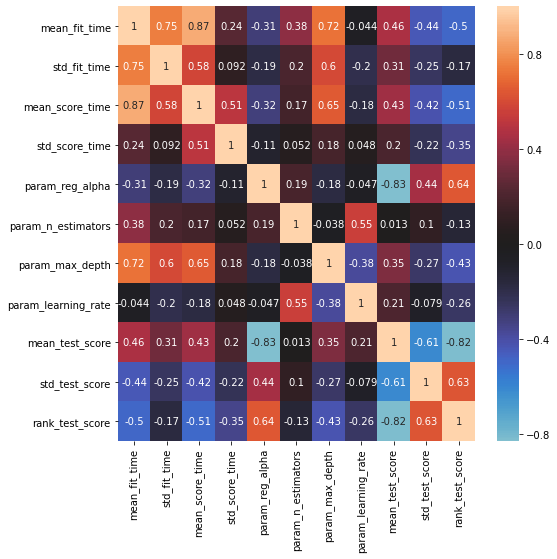

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

print('Best Parameters: ', rand_cv.best_params_)
print('Best Score: ', rand_cv.best_score_)
best_model = rand_cv.best_estimator_
res = rand_cv.cv_results_
res.pop('params',None)
res.pop('split0_test_score',None)
res.pop('split1_test_score',None)

df = pd.DataFrame(res).sort_values('rank_test_score')
df['param_reg_alpha'] = df['param_reg_alpha'].astype(np.float64)
df['param_n_estimators'] = df['param_n_estimators'].astype(np.float64)
df['param_learning_rate'] = df['param_learning_rate'].astype(np.float64)
df['param_max_depth'] = df['param_max_depth'].astype(np.float64)

display(df)

# display corr heat map
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), center=0, annot=True)


Coarse Estimation Best Model Train Accuracy: 0.9759
Coarse Estimation Best Model Test Accuracy:  0.8965
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       275
           1       0.86      0.88      0.87       224
           2       0.91      0.92      0.92       695
           3       0.77      0.76      0.76       159
           4       0.95      0.92      0.94       581
           5       0.68      0.73      0.70        66

    accuracy                           0.90      2000
   macro avg       0.85      0.86      0.85      2000
weighted avg       0.90      0.90      0.90      2000

Unweighted Average AUC: 0.9915


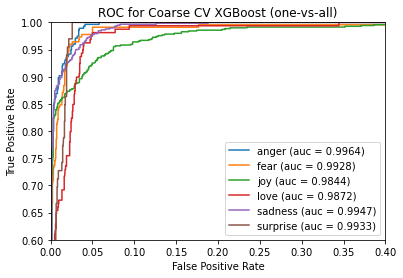

In [119]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Y_test_pred = best_model.predict(X_test)
Y_trainval_pred = best_model.predict(X_trainval)
print('Coarse Estimation Best Model Train Accuracy: {:.4}'.format(accuracy_score(Y_trainval, Y_trainval_pred)))
print('Coarse Estimation Best Model Test Accuracy: ', accuracy_score(Y_test, Y_test_pred))
print(classification_report(Y_test, Y_test_pred))


Y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3, 4, 5])
Y_test_proba = best_model.predict_proba(X_test)
plot_mc_roc(Y_test_bin, Y_test_proba, n_classes=6,
            title='ROC for Coarse CV XGBoost (one-vs-all)')


### Analysis of Coarse Hyperparameter Estimation

The coarse estimation of hyperparameter performed provides an initial assessment of how the design responds to changes in different parameters. We keep the search space coarse to reduce computation time, however this reduction inherently makes the cross-validation sparse meaning we can only initially infer some general trends. Additional fine-tuning will be performed based on these results.

The primary takeaways from initial coarse estimation are as follows:
- Regularization has a strong negative correlation with the the F1 validation score meaning that alpha regularization should be kept small or not used at all
- Max tree depth and the learning rate both have significant positive correlation with the F1 validation score. This means that deeper trees and higher learning rates tend to increase the accuracy of the model. This is supported by the fact that most top scoring runs in the table have a high value of one or both of those parameters.
- The number of trees used had no correlation to the validation scores. This indicates that the number of trees is a less important parameter than the the others used. We know that higher number of estimators will tend to perform better, however these results show that the impact is less significant than that of other variables. 

The performance of the best model selected exceeds that of the random forrest model previously analysed. 

**Note that these takeaways are specific to the models tested, and will not necessarily hold true for all design spaces.** For example, while learning rate had a positive correlation, that will not always be the case depending on the number of estimators used.

## Hyperparameter Fine-Tuning

Now that we have a general sense for where the optimal model lies in the design space, we can perform more fine-tuning via additional cross-validation. For the sake of reducing computational requirements we wil tune a subset of parameters at a time. Regularization showed no evidence of benefit in the coarse estimation so it is not included in the tuning.

### Learning Rate and N-Estimators Tuning

The learning rate proved to have a positive correlation with accuracy. Although we observed that the number of estimators (trees) had lower impact on the score, we know that the number of trees and the optimal learning rate are closely connected, with fewer estimators requiring a higher learning rate and visa-versa. From coarse estimation we know higher depths of trees tend to perform better. For the sake of training speed we use a relatively low depth in order to evaluate the best learning rate and n-estimators, and then in a future step evaluate the best value for the depth of the trees.

In [99]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

clf = XGBClassifier(random_state=0, eval_metric='mlogloss',use_label_encoder=False)

params = {'n_estimators': [50, 250, 500, 750],
          'max_depth': [5],
          'learning_rate': [.1, .5, 1, 1.5]#[.5, 2, 5]
          }

grid_cv = GridSearchCV(clf,param_grid=params, scoring='f1_macro', verbose=1, n_jobs=-1, cv=2)
grid_cv.fit(X_trainval, Y_trainval)


Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mon...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

print('Best Parameters: ', grid_cv.best_params_)
print('Best Score: ', grid_cv.best_score_)
best_model = grid_cv.best_estimator_
res = grid_cv.cv_results_
res.pop('params', None)
res.pop('split0_test_score', None)
res.pop('split1_test_score', None)

df = pd.DataFrame(res).sort_values('rank_test_score')

display(df)

Best Parameters:  {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 250}
Best Score:  0.8572961642816965


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score,rank_test_score
5,2227.741007,0.063693,1.019919,0.044897,0.5,5,250,0.857296,0.000703,1
9,2237.228608,3.729785,0.872056,0.015128,1,5,250,0.856001,0.000773,2
6,4358.083454,15.562771,1.492305,0.011712,0.5,5,500,0.855297,0.000055,3
2,4473.823014,11.417638,1.692872,0.167385,0.1,5,500,0.854585,0.001477,4
3,6684.228642,2.728051,2.309218,0.229360,0.1,5,750,0.854470,0.000239,5
7,6626.798655,19.304823,2.086200,0.504104,0.5,5,750,0.853981,0.000411,6
10,4535.125391,3.822361,1.335660,0.230829,1,5,500,0.851005,0.000704,7
8,445.813845,0.521674,0.546072,0.002441,1,5,50,0.850213,0.000115,8
11,5761.272615,2.080991,1.552846,0.279252,1,5,750,0.849236,0.000859,9
1,2296.332590,5.608351,1.529881,0.369416,0.1,5,250,0.847712,0.002229,10


Best Model Train Accuracy: 0.9638
Best Model Test Accuracy:  0.8985
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       275
           1       0.88      0.88      0.88       224
           2       0.91      0.92      0.92       695
           3       0.76      0.79      0.77       159
           4       0.95      0.92      0.94       581
           5       0.70      0.76      0.73        66

    accuracy                           0.90      2000
   macro avg       0.85      0.86      0.86      2000
weighted avg       0.90      0.90      0.90      2000

Unweighted Average AUC: 0.9908


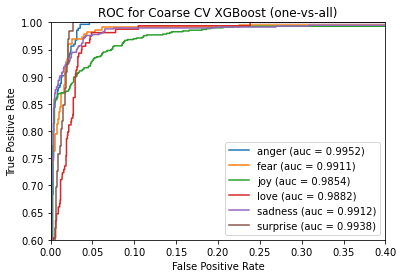

In [121]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Y_test_pred = best_model.predict(X_test)
Y_trainval_pred = best_model.predict(X_trainval)
print('Best Model Train Accuracy: {:.4}'.format(accuracy_score(Y_trainval, Y_trainval_pred)))
print('Best Model Test Accuracy: ', accuracy_score(Y_test, Y_test_pred))
print(classification_report(Y_test, Y_test_pred))


Y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3, 4, 5])
Y_test_proba = best_model.predict_proba(X_test)
plot_mc_roc(Y_test_bin, Y_test_proba, n_classes=6,
            title='ROC for Coarse CV XGBoost (one-vs-all)')

In [131]:
from xgboost import XGBClassifier

best_try_clf = XGBClassifier(n_estimators=250, learning_rate=.5, max_depth=25, n_jobs=-1, random_state=0, eval_metric='mlogloss',use_label_encoder=False)
best_try_clf.fit(X_trainval, Y_trainval)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=25, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

Coarse Estimation Best Model Train Accuracy: 0.9945
Coarse Estimation Best Model Test Accuracy:  0.894
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       275
           1       0.86      0.88      0.87       224
           2       0.91      0.92      0.91       695
           3       0.76      0.72      0.74       159
           4       0.94      0.93      0.94       581
           5       0.69      0.77      0.73        66

    accuracy                           0.89      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.89      0.89      0.89      2000

Unweighted Average AUC: 0.9905


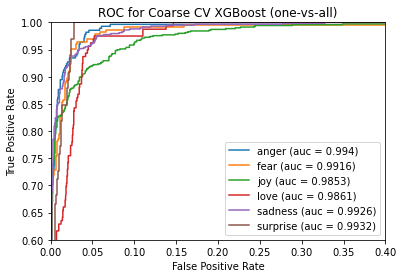

In [132]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Y_test_pred = best_try_clf.predict(X_test)
Y_trainval_pred = best_try_clf.predict(X_trainval)
print('Coarse Estimation Best Model Train Accuracy: {:.4}'.format(accuracy_score(Y_trainval, Y_trainval_pred)))
print('Coarse Estimation Best Model Test Accuracy: ', accuracy_score(Y_test, Y_test_pred))
print(classification_report(Y_test, Y_test_pred))


Y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3, 4, 5])
Y_test_proba = best_try_clf.predict_proba(X_test)
plot_mc_roc(Y_test_bin, Y_test_proba, n_classes=6,
            title='ROC for Coarse CV XGBoost (one-vs-all)')

In [133]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

clf = XGBClassifier(random_state=0, eval_metric='mlogloss',
                    use_label_encoder=False)

params = {'n_estimators': [250],
          'max_depth': [1, 5, 10, 17, 25, 20],
          'learning_rate': [.5]
          }

grid_cv = GridSearchCV(clf,param_grid=params, scoring='f1_macro', verbose=1, n_jobs=-1, cv=2)
grid_cv.fit(X_trainval, Y_trainval)


Fitting 2 folds for each of 6 candidates, totalling 12 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mon...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                

In [134]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

print('Best Parameters: ', grid_cv.best_params_)
print('Best Score: ', grid_cv.best_score_)
best_model = grid_cv.best_estimator_
res = grid_cv.cv_results_
res.pop('params', None)
res.pop('split0_test_score', None)
res.pop('split1_test_score', None)

df = pd.DataFrame(res).sort_values('rank_test_score')

display(df)


Best Parameters:  {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 250}
Best Score:  0.8572961642816965


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score,rank_test_score
1,2184.941503,2.404570,1.098064,0.121675,0.5,5,250,0.857296,0.000703,1
2,4647.535027,10.977057,1.966965,0.315217,0.5,10,250,0.855853,0.001026,2
5,6798.978949,9.337144,2.106980,0.244814,0.5,20,250,0.852277,0.001929,3
3,7036.759437,5.023702,1.990101,0.211328,0.5,17,250,0.852122,0.000966,4
0,572.882369,0.898597,0.577955,0.042387,0.5,1,250,0.849801,0.003179,5
4,8453.082877,2.541184,1.626045,0.137253,0.5,25,250,0.849659,0.002565,6
